In [82]:
import numpy as np
import time
from scipy.special import gammaln
import torch

import scipy.stats as stats
import train_2D_rt_v1 as tr
import tools_2D_rt_v1 as tt

# Generate Data


Make sure you have also copied '/home/mcarilli/CME/2D_CME/learning_environment/train_2D_rt_v1.py' and
'/home/mcarilli/CME/2D_CME/learning_environment/tools_2D_rt_v1.py' to your file location. 


If you want to load in pre-generated data, there are 20 batches of 5,120 are already stored in:


1. '/home/mcarilli/CME/2D_CME/learning_environment/training_data_quadvec/'
2. '/home/mcarilli/CME/2D_CME/learning_environment/training_data_fixedquad/'


There are also 10 batches of 512 parameters in 1 (_fixedquad/_) and 10 batches of 256 parameterc in 2 (_quadvec/_). 
generated using quad_vec and fixed_quad, respectively. 


If you want to make and store other data files, here is some code:

In [83]:
# define your data path

path =  './training_data_quadvec/'

In [4]:
set_size = 256
num_files = 10
N = num_files*set_size


params = tr.generate_param_vectors(N)

In [ ]:
# define your xmax function!! 

def xmax_fun(xmax):

    return(4.5*xmax)

In [ ]:
#generate_sets(set_size,num_files,param_vectors,method,xmax_fun,NCOR,path_to_directory)
tr.generate_sets_pcme(set_size = 256,num_files=num_files,param_vectors = params,
                 method = 'quad_vec',
                 xmax_fun=xmax_fun,
                 NCOR = 60,
                 path_to_directory=path)

# Train ! 


Here are the generating grid and get_ypred_at_RT functions! 

In [199]:
def generate_grid(npdf,VAR,MU,quantiles=None):
    
    if quantiles=='PRESET':
        logstd = torch.sqrt(torch.log((VAR/MU**2)+1))
        logmean = torch.log(MU**2/torch.sqrt(VAR+MU**2))
        translin_0 = torch.exp(logmean[0]+logstd[0]*NORM_nas)
        translin_1 = torch.exp(logmean[1]+logstd[1]*NORM_mat)
        return translin_0,translin_1
        return(translin)
    
    
def generate_grid_3(npdf,VAR,MU,p,quantiles=None):
    
    if quantiles=='PRESET':
        logstd = torch.sqrt(torch.log((VAR/MU**2)+1))
        logmean = torch.log(MU**2/torch.sqrt(VAR+MU**2))
        
        # calculate sigma_ij
        var_ij = p[0]**2/ (p[1]+p[2]) 
        logst_ij = torch.log( var_ij * np.exp(-(MU[0]+MU[1]+0.5*VAR[0]+0.5*VAR[1])) + 1 )
        
        translin_0 = torch.exp(logmean[0]+logstd[0]*NORM_nas+logst_ij*NORM_mat)
        translin_1 = torch.exp(logmean[0]+logstd[0]*NORM_mat+logst_ij*NORM_nas)
        
        return translin_0,translin_1
        return(translin)
    
def generate_grid_2(npdf,VAR,MU,l_out,quantiles=None):
    
    
    A,B,C,D = l_out
    
    
    norm_nas = A*NORM_nas + B*NORM_mat
    norm_mat = C*NORM_nas + D*NORM_mat
    
    #norm_nas = norm_nas/torch.sum(norm_nas)
    #norm_mat = norm_nas/torch.sum(norm_mat)
    print('norm_nas:',norm_nas)
    #print('norm_mat:',norm_mat)
    
    if quantiles=='PRESET':
        logstd = torch.sqrt(torch.log((VAR/MU**2)+1))
        logmean = torch.log(MU**2/torch.sqrt(VAR+MU**2))
        translin_0 = torch.exp(logmean[0]+logstd[0]*NORM_nas)
        translin_1 = torch.exp(logmean[1]+logstd[1]*NORM_mat)
        return translin_0,translin_1
        return(translin)

    

def get_ypred_at_RT(p,npdf,w,hyp,l_out,quantiles='PRESET',
                   first_special=False,special_std='tail_prob'):
    p = 10**p
    MU, VAR, STD, xmax = tr.get_moments(p)
    
    print(hyp)
    print('l_out',l_out)

    
    #NORM_nas = lg[:npdf[0]]
    #grid_nas = lg[:npdf[0]]
    #NORM_mat = lg[npdf[0]:]
    #grid_mat = lg[npdf[0]:]
    
    grid_nas,grid_mat = generate_grid_3(npdf,VAR,MU,p,quantiles=quantiles)
    print('grid_nas',grid_nas)

    
    #grid_nas = lg[0]* grid_nas_i + lg[1]*grid_mat_i    
    #grid_mat = lg[2]* grid_nas_i + lg[3]*grid_mat_i  
    #two separate variables. a bit ugly and leaves room for error. 
    #grid_nas,grid_mat = generate_grid(npdf,VAR,MU,NORM_nas,NORM_mat,quantiles=quantiles) 
    # print('size grid_nas',grid_nas.shape)
    # no zs implementation yet. not sure i want to implement it.

    s_nas = torch.zeros(npdf[0])
    s_mat = torch.zeros(npdf[1])

    spec = 0 if first_special else -1
    if first_special:
        s_nas[1:] = torch.diff(grid_nas)
        s_mat[1:] = torch.diff(grid_mat)
    else: #last special... for now
        s_nas[:-1] = torch.diff(grid_nas)
        s_mat[:-1] = torch.diff(grid_mat)
    
    if special_std == 'mean':
        s_nas[spec] = grid_nas[spec]
        s_mat[spec] = grid_mat[spec]
    elif special_std == 'neighbor': #assign_neighbor_to_special
        s_nas[spec] = s_nas[1] if first_special else s_nas[-2]
        s_mat[spec] = s_mat[1] if first_special else s_mat[-2]
    elif special_std == 'tail_prob':
        if first_special:
            print('If you are using this setting, you are doing something wrong.')
        t_max = torch.log(p[1]/p[2])/(p[1] - p[2])
        f = (torch.exp(-p[2]*t_max) - torch.exp(-p[1]*t_max)) * p[1]/(p[1] - p[2]) * p[0]
        tailratio = 1/(1+1/f) #the mature tail ratio
        s_mat[spec] = torch.sqrt(grid_mat[spec] / (1-tailratio))
        tailratio = p[0]/(1+p[0]) #the nascent tail ratio
        s_nas[spec] = torch.sqrt(grid_nas[spec] / (1-tailratio))
    else:
        print('did not specify a standard deviation convention!')
    
    s_nas *= hyp
    s_mat *= hyp
    v_nas = s_nas**2
    v_mat = s_mat**2

    r_nas = grid_nas**2/(v_nas-grid_nas)
    p_nas = 1-grid_nas/v_nas 
    r_mat = grid_mat**2/(v_mat-grid_mat)
    p_mat = 1-grid_mat/v_mat 
    
    xgrid_nas = torch.arange(xmax[0]+1)
    xgrid_mat = torch.arange(xmax[1]+1)
    
    gammaln_xgrid_nas = lnfactorial[1:(xmax[0]+2)]
    gammaln_xgrid_mat = lnfactorial[1:(xmax[1]+2)] 

    Y = torch.zeros((xmax[0]+1,xmax[1]+1))

    for i in range(npdf[0]):
        lnas = -grid_nas[i] + xgrid_nas * torch.log(grid_nas[i]) - gammaln_xgrid_nas
        if p_nas[i] > 1e-10:
            lnas += torch.special.gammaln(xgrid_nas+r_nas[i]) - torch.special.gammaln(r_nas[i]) \
                - xgrid_nas*torch.log(r_nas[i] + grid_nas[i]) + grid_nas[i] \
                + r_nas[i]*torch.log(1-p_nas[i])
        for j in range(npdf[1]):
            lmat =  - grid_mat[j] + xgrid_mat * torch.log(grid_mat[j]) - gammaln_xgrid_mat
            if p_mat[j] > 1e-10:
                lmat += torch.special.gammaln(xgrid_mat+r_mat[j]) - torch.special.gammaln(r_mat[j]) \
                - xgrid_mat*torch.log(r_mat[j] + grid_mat[j]) + grid_mat[j] \
                + r_mat[j]*torch.log(1-p_mat[j]) #wasteful: we're recomputing a lot of stuff.
            Y += w[i*npdf[1] + j] * torch.exp(lnas[:,None] + lmat[None,:])
            #note convention change. Y = the predicted PMF is now returned in the same shape as the original histogram.
            #this is fine bc Y is flattened anyway later on down the line.
    return Y




In [187]:
# define NORM and YPRED_FUN
npdf = np.array([10,10])

if npdf[0] == npdf[1]:
    n = np.arange(npdf[0])
    q = np.flip((np.cos((2*(n+1)-1)/(2*npdf[0])*np.pi)+1)/2)
    NORM = stats.norm.ppf(q)
    NORM_nas = torch.tensor(NORM)
    NORM_mat = NORM_nas
else:
    n = np.arange(npdf[0])
    q = np.flip((np.cos((2*(n+1)-1)/(2*npdf[0])*np.pi)+1)/2)
    print(q)
    NORM_nas = torch.tensor(stats.norm.ppf(q))
    n = np.arange(npdf[1])
    q = np.flip((np.cos((2*(n+1)-1)/(2*npdf[1])*np.pi)+1)/2)
    print(q)
    NORM_mat = torch.tensor(stats.norm.ppf(q))
    
lnfactorial = torch.special.gammaln(torch.arange(1003))

YPRED_FUN = lambda p, y, npdf, w, hyp, l_out: get_ypred_at_RT(p=p,
                                            y=y,npdf=npdf,w=w,hyp=hyp,l_out=l_out,
                                               grid_method='logn',quantiles='PRESET')

Load in how many training and testing files you want. Get data now also needs set size

In [95]:
train_list, test_list = tr.get_data(set_size = 256,
                                    number_of_training_files=1,
                                 number_of_testing_files=1,total_files=3,file_path=path)

In [96]:
import train_2D_rt_v2 as tr2

In [118]:
import importlib
importlib.reload(tr2)

<module 'train_2D_rt_v2' from '/home/mcarilli/CME/2D_CME/learning_environment/train_2D_rt_v2.py'>

In [130]:
l_out = torch.tensor([0.5923, 0.5799, 0.6740, 0.4985])
A,B,C,D = l_out


A*NORM_mat + B*NORM_nas

tensor([-2.9341, -1.8787, -1.2329, -0.7077, -0.2313,  0.2313,  0.7077,  1.2329,
         1.8787,  2.9341], dtype=torch.float64)

In [201]:
t1 = time.time()
e,b,t,model = tr2.train_MLP(train_list[0:51],test_list[0:12],num_epochs=5,
                           npdf=[10,10],batchsize=26,get_ypred_at_RT=get_ypred_at_RT,
                           metric='kld',learning_rate=1e-3,MLP=1)
t2 = time.time()

print(t2-t1)



# IF YOU WANT TO SAVE
#path1 = 'DEFINE/PATH/TO/STORE'
#np.save(path1+'e_t',[e,t])
#torch.save(model.state_dict(),'./test_MODEL')

Epoch Number: 0
tensor([4.3589], grad_fn=<SelectBackward0>)
l_out tensor([0.6158, 0.5793, 0.5468, 0.3515], grad_fn=<SelectBackward0>)
grid_nas tensor([7.6221e-03, 2.7967e-02, 6.1961e-02, 1.1832e-01, 2.1277e-01, 3.7618e-01,
        6.7647e-01, 1.2918e+00, 2.8620e+00, 1.0501e+01], dtype=torch.float64)
training metval:  tensor(0.3227, grad_fn=<AddBackward0>)
tensor([4.3548], grad_fn=<SelectBackward0>)
l_out tensor([0.5818, 0.5672, 0.5489, 0.3192], grad_fn=<SelectBackward0>)
grid_nas tensor([ 0.5306,  0.9950,  1.4618,  1.9988,  2.6548,  3.4972,  4.6449,  6.3512,
         9.3312, 17.4978], dtype=torch.float64)
training metval:  tensor(1.2741, grad_fn=<AddBackward0>)
tensor([4.3593], grad_fn=<SelectBackward0>)
l_out tensor([0.5882, 0.5693, 0.5505, 0.3333], grad_fn=<SelectBackward0>)
grid_nas tensor([ 1.6184,  3.0299,  4.4471,  6.0758,  8.0638, 10.6150, 14.0882, 19.2479,
        28.2509, 52.8901], dtype=torch.float64)
training metval:  tensor(2.7892, grad_fn=<AddBackward0>)
tensor([4.3522], g

tensor([4.0682], grad_fn=<SelectBackward0>)
l_out tensor([0.5781, 0.5679, 0.5515, 0.3164], grad_fn=<SelectBackward0>)
grid_nas tensor([ 2.8896,  4.4610,  5.8187,  7.2223,  8.7863, 10.6286, 12.9302, 16.0492,
        20.9342, 32.3181], dtype=torch.float64)
tensor([4.0645], grad_fn=<SelectBackward0>)
l_out tensor([0.6133, 0.5737, 0.5423, 0.3510], grad_fn=<SelectBackward0>)
grid_nas tensor([5.8268e-04, 2.8305e-03, 7.4458e-03, 1.6350e-02, 3.3370e-02, 6.6721e-02,
        1.3618e-01, 2.9903e-01, 7.8661e-01, 3.8212e+00], dtype=torch.float64)
tensor([4.0563], grad_fn=<SelectBackward0>)
l_out tensor([0.5752, 0.5620, 0.5533, 0.3383], grad_fn=<SelectBackward0>)
grid_nas tensor([ 40.0209,  63.2893,  83.7776, 105.2395, 129.4275, 158.2258, 194.5920,
        244.4420, 323.5739, 511.7015], dtype=torch.float64)
tensor([4.0586], grad_fn=<SelectBackward0>)
l_out tensor([0.6087, 0.5803, 0.5542, 0.3563], grad_fn=<SelectBackward0>)
grid_nas tensor([  2.9203,   6.2272,   9.8975,  14.4271,  20.3061,  28.2999, 

training metval:  tensor(39.8807, grad_fn=<AddBackward0>)
tensor([4.0645], grad_fn=<SelectBackward0>)
l_out tensor([0.6133, 0.5737, 0.5423, 0.3510], grad_fn=<SelectBackward0>)
grid_nas tensor([5.8268e-04, 2.8305e-03, 7.4458e-03, 1.6350e-02, 3.3370e-02, 6.6721e-02,
        1.3618e-01, 2.9903e-01, 7.8661e-01, 3.8212e+00], dtype=torch.float64)
training metval:  tensor(40.3214, grad_fn=<AddBackward0>)
tensor([4.0616], grad_fn=<SelectBackward0>)
l_out tensor([0.5795, 0.5704, 0.5564, 0.3291], grad_fn=<SelectBackward0>)
grid_nas tensor([ 71.3032,  94.3034, 111.8987, 128.6017, 145.8998, 164.9219, 187.1054,
        215.0345, 255.1560, 337.4612], dtype=torch.float64)
training metval:  tensor(44.3525, grad_fn=<AddBackward0>)
tensor([4.0616], grad_fn=<SelectBackward0>)
l_out tensor([0.6084, 0.5665, 0.5394, 0.3553], grad_fn=<SelectBackward0>)
grid_nas tensor([3.7833e-04, 1.9824e-03, 5.4622e-03, 1.2455e-02, 2.6305e-02, 5.4369e-02,
        1.1483e-01, 2.6183e-01, 7.2141e-01, 3.7802e+00], dtype=torch.

training metval:  tensor(34.2593, grad_fn=<AddBackward0>)
tensor([3.7398], grad_fn=<SelectBackward0>)
l_out tensor([0.5793, 0.5566, 0.5446, 0.3383], grad_fn=<SelectBackward0>)
grid_nas tensor([ 0.2314,  0.6102,  1.1044,  1.7893,  2.7718,  4.2399,  6.5680, 10.6410,
        19.2600, 50.7864], dtype=torch.float64)
training metval:  tensor(38.6859, grad_fn=<AddBackward0>)
tensor([3.7293], grad_fn=<SelectBackward0>)
l_out tensor([0.6268, 0.5760, 0.5434, 0.3800], grad_fn=<SelectBackward0>)
grid_nas tensor([8.2141e-04, 4.8779e-03, 1.4510e-02, 3.5210e-02, 7.8687e-02, 1.7181e-01,
        3.8395e-01, 9.3172e-01, 2.7715e+00, 1.6458e+01], dtype=torch.float64)
training metval:  tensor(39.4922, grad_fn=<AddBackward0>)
tensor([3.7451], grad_fn=<SelectBackward0>)
l_out tensor([0.5806, 0.5660, 0.5532, 0.3371], grad_fn=<SelectBackward0>)
grid_nas tensor([ 21.2597,  33.9212,  45.1478,  56.9657,  70.3409,  86.3287, 106.5982,
        134.5013, 179.0162, 285.6311], dtype=torch.float64)
training metval:  ten

training metval:  tensor(5.5166, grad_fn=<AddBackward0>)
tensor([3.4256], grad_fn=<SelectBackward0>)
l_out tensor([0.6328, 0.5828, 0.5447, 0.3768], grad_fn=<SelectBackward0>)
grid_nas tensor([6.2870e-04, 3.5392e-03, 1.0189e-02, 2.4076e-02, 5.2523e-02, 1.1203e-01,
        2.4439e-01, 5.7748e-01, 1.6625e+00, 9.3589e+00], dtype=torch.float64)
training metval:  tensor(5.7215, grad_fn=<AddBackward0>)
tensor([3.3872], grad_fn=<SelectBackward0>)
l_out tensor([0.6135, 0.5719, 0.5494, 0.3786], grad_fn=<SelectBackward0>)
grid_nas tensor([1.5905e-01, 6.3952e-01, 1.4985e+00, 2.9948e+00, 5.6125e+00, 1.0329e+01,
        1.9358e+01, 3.8688e+01, 9.0650e+01, 3.6449e+02], dtype=torch.float64)
training metval:  tensor(7.1544, grad_fn=<AddBackward0>)
tensor([3.4589], grad_fn=<SelectBackward0>)
l_out tensor([0.5795, 0.5704, 0.5564, 0.3291], grad_fn=<SelectBackward0>)
grid_nas tensor([ 71.3032,  94.3034, 111.8987, 128.6017, 145.8998, 164.9219, 187.1054,
        215.0345, 255.1560, 337.4612], dtype=torch.flo

l_out tensor([0.6087, 0.5803, 0.5542, 0.3563], grad_fn=<SelectBackward0>)
grid_nas tensor([  2.9203,   6.2272,   9.8975,  14.4271,  20.3061,  28.2999,  39.8319,
         58.0610,  92.2826, 196.7802], dtype=torch.float64)
tensor([3.1911], grad_fn=<SelectBackward0>)
l_out tensor([0.5818, 0.5672, 0.5489, 0.3192], grad_fn=<SelectBackward0>)
grid_nas tensor([ 0.5306,  0.9950,  1.4618,  1.9988,  2.6548,  3.4972,  4.6449,  6.3512,
         9.3312, 17.4978], dtype=torch.float64)
tensor([3.1444], grad_fn=<SelectBackward0>)
l_out tensor([0.6133, 0.5737, 0.5423, 0.3510], grad_fn=<SelectBackward0>)
grid_nas tensor([5.8268e-04, 2.8305e-03, 7.4458e-03, 1.6350e-02, 3.3370e-02, 6.6721e-02,
        1.3618e-01, 2.9903e-01, 7.8661e-01, 3.8212e+00], dtype=torch.float64)
tensor([3.1149], grad_fn=<SelectBackward0>)
l_out tensor([0.5752, 0.5620, 0.5533, 0.3383], grad_fn=<SelectBackward0>)
grid_nas tensor([ 40.0209,  63.2893,  83.7776, 105.2395, 129.4275, 158.2258, 194.5920,
        244.4420, 323.5739, 511.70

training metval:  tensor(47.6674, grad_fn=<AddBackward0>)
tensor([3.1126], grad_fn=<SelectBackward0>)
l_out tensor([0.6065, 0.5668, 0.5407, 0.3540], grad_fn=<SelectBackward0>)
grid_nas tensor([1.0070e-03, 4.7933e-03, 1.2453e-02, 2.7069e-02, 5.4744e-02, 1.0848e-01,
        2.1940e-01, 4.7691e-01, 1.2390e+00, 5.8976e+00], dtype=torch.float64)
training metval:  tensor(50.1799, grad_fn=<AddBackward0>)
tensor([3.1349], grad_fn=<SelectBackward0>)
l_out tensor([0.5872, 0.5624, 0.5441, 0.3350], grad_fn=<SelectBackward0>)
grid_nas tensor([ 0.0475,  0.1352,  0.2564,  0.4315,  0.6919,  1.0942,  1.7543,  2.9521,
         5.5982, 15.9303], dtype=torch.float64)
training metval:  tensor(52.3549, grad_fn=<AddBackward0>)
tensor([2.9713], grad_fn=<SelectBackward0>)
l_out tensor([0.5821, 0.5694, 0.5504, 0.3164], grad_fn=<SelectBackward0>)
grid_nas tensor([ 0.8520,  1.4768,  2.0678,  2.7189,  3.4852,  4.4355,  5.6856,  7.4758,
        10.4674, 18.1438], dtype=torch.float64)
tensor([2.8176], grad_fn=<Selec

In [81]:
torch.save(model.state_dict(),'./quadvec_models/03172022_20npdf_256params_20e_hyp_MODEL')

In [121]:
e,t,b

(array([0.58996469, 0.51665872, 0.45959774, 0.41835144, 0.39078566]),
 [0.5166587308049202,
  0.45959772417942685,
  0.41835141244033974,
  0.39078569288055104,
  0.37323154757420224],
 array([0.58996469, 0.51665872, 0.45959774, 0.41835144, 0.39078566]))

# Plotting!


If you have already stored your model, load it in!

In [128]:
# pre-loaded model

path = './dir_03032022/'
npdf = [10,11]
model = tr.my_MLP1(3,npdf[0]*npdf[1])
model.load_state_dict(torch.load(path+'MODEL_kld'))
model.eval()
#array = np.load(path+ 'mselog.npy',allow_pickle=True)
#e = array[0]
#t = array[1]

my_MLP1(
  (input): Linear(in_features=3, out_features=256, bias=True)
  (hidden1): Linear(in_features=256, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=128, bias=True)
  (hidden3): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=110, bias=True)
  (softmax): Softmax(dim=1)
)

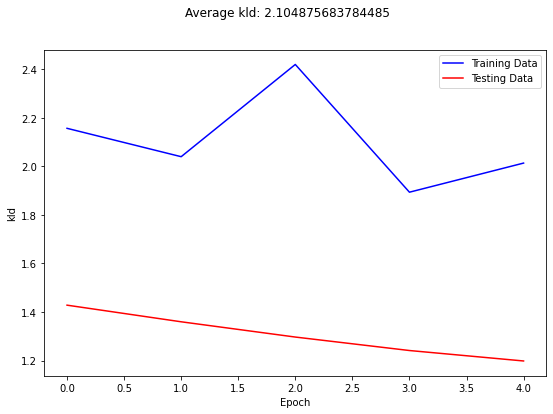

In [202]:
metric = 'kld'

tt.plot_training(e,t,metric)

## Metric Histogram

In [102]:


# i know the function still says test_klds, but now it calculates whatever metric you give it

metrics, metric_mean = tr2.calculate_test_metrics(test_list=train_list[0:12],npdf= [10,11],
                                        model=model,get_ypred_at_RT=get_ypred_at_RT,
                                             metric = metric)

tensor([-0.4744, -0.4549, -0.2674, -0.0850,  0.0967,  0.5986,  0.6194,  0.6586,
         0.6631,  1.4147], grad_fn=<SortBackward0>)
size grid_nas torch.Size([10])
tensor([-0.4760, -0.4520, -0.2730, -0.0879,  0.0950,  0.5891,  0.6164,  0.6552,
         0.6634,  1.4083], grad_fn=<SortBackward0>)
size grid_nas torch.Size([10])
tensor([-0.4676, -0.4608, -0.2561, -0.0867,  0.1023,  0.6167,  0.6175,  0.6585,
         0.6709,  1.4291], grad_fn=<SortBackward0>)
size grid_nas torch.Size([10])
tensor([-0.4719, -0.4584, -0.2580, -0.0765,  0.0975,  0.6124,  0.6253,  0.6582,
         0.6677,  1.4214], grad_fn=<SortBackward0>)
size grid_nas torch.Size([10])
tensor([-0.4753, -0.4549, -0.2643, -0.0696,  0.0930,  0.6052,  0.6301,  0.6472,
         0.6724,  1.4117], grad_fn=<SortBackward0>)
size grid_nas torch.Size([10])
tensor([-0.4752, -0.4577, -0.2671, -0.0795,  0.0969,  0.6053,  0.6265,  0.6600,
         0.6625,  1.4197], grad_fn=<SortBackward0>)
size grid_nas torch.Size([10])
tensor([-0.4747, -0.45

In [103]:
metrics

array([0.41969925, 0.3417404 , 0.08398814, 0.18781659, 0.54304856,
       1.3641516 , 0.19310889, 0.13790148, 0.07387512, 1.0617125 ,
       0.08024925, 0.06544714])

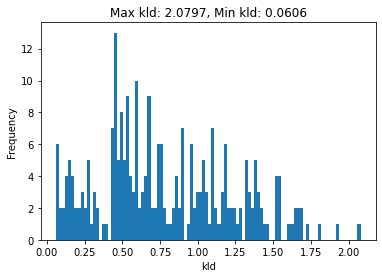

In [98]:
tt.plot_histogram(metrics,bins=10,metric=metric)

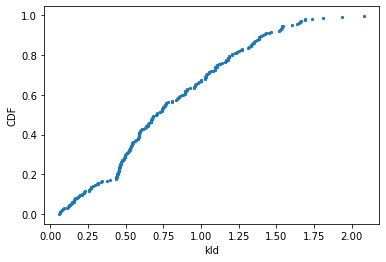

In [99]:
tt.plot_CDF(metrics,metric)

## Plot Param Quantiles

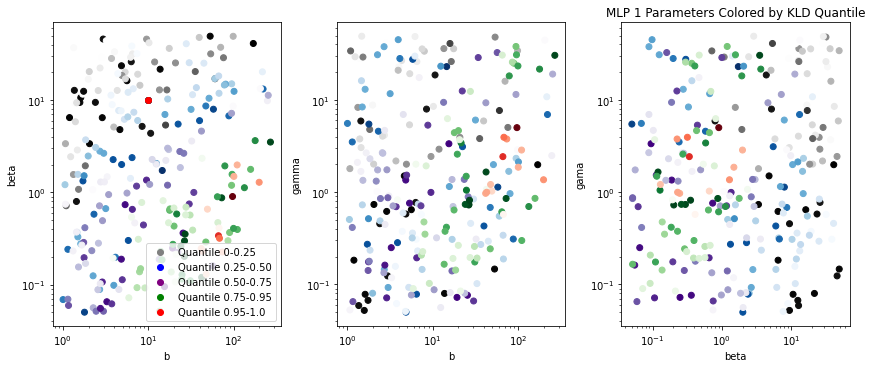

In [100]:
tt.plot_param_quantiles(metrics,train_list,model)

## Plot PMFs

In [16]:
import tools_2D_rt_v2 as tt2

In [45]:
importlib.reload(tt2)

<module 'tools_2D_rt_v2' from '/home/mcarilli/CME/2D_CME/learning_environment/tools_2D_rt_v2.py'>

tensor([1.3275], grad_fn=<SelectBackward0>)
l_out tensor([0.5178, 0.4891, 0.4264, 0.5588], grad_fn=<SelectBackward0>)
norm_nas: tensor([-2.5205, -1.6139, -1.0591, -0.6080, -0.1987,  0.1987,  0.6080,  1.0591,
         1.6139,  2.5205], dtype=torch.float64, grad_fn=<AddBackward0>)
grid_nas tensor([3.3064e-03, 1.1881e-02, 2.5987e-02, 4.9111e-02, 8.7483e-02, 1.5326e-01,
        2.7300e-01, 5.1594e-01, 1.1285e+00, 4.0550e+00], dtype=torch.float64)
tensor([1.3275], grad_fn=<SelectBackward0>)
l_out tensor([0.5178, 0.4891, 0.4264, 0.5588], grad_fn=<SelectBackward0>)
norm_nas: tensor([-2.5205, -1.6139, -1.0591, -0.6080, -0.1987,  0.1987,  0.6080,  1.0591,
         1.6139,  2.5205], dtype=torch.float64, grad_fn=<AddBackward0>)
grid_nas tensor([3.3064e-03, 1.1881e-02, 2.5987e-02, 4.9111e-02, 8.7483e-02, 1.5326e-01,
        2.7300e-01, 5.1594e-01, 1.1285e+00, 4.0550e+00], dtype=torch.float64)
tensor([1.1620], grad_fn=<SelectBackward0>)
l_out tensor([0.5262, 0.4940, 0.4314, 0.5529], grad_fn=<Select

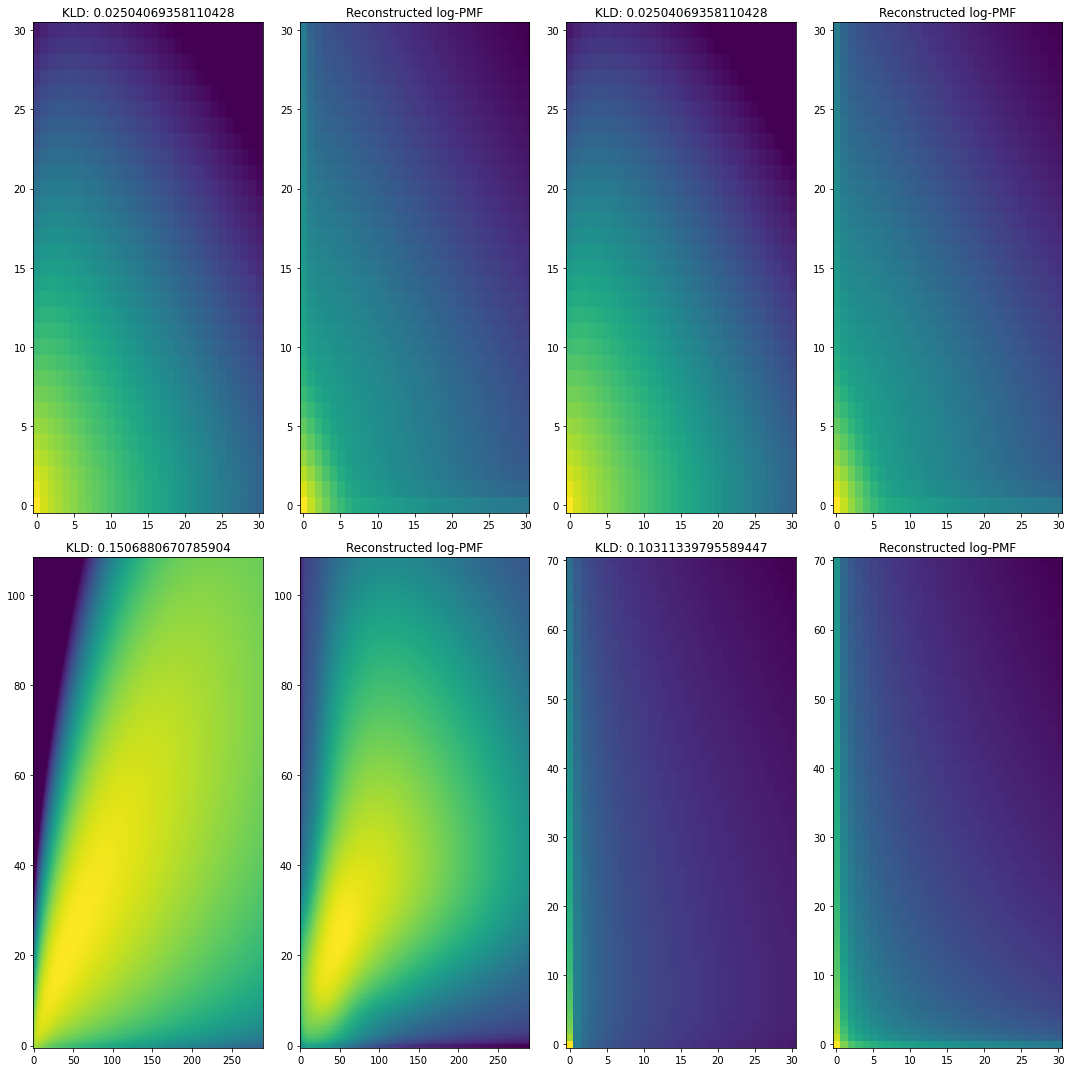

In [198]:
tt2.plot_PMF_grid(file_list=train_list[0:12],npdf=[10,10],nrows=2,
                 ncols=2,model=model,get_ypred_at_RT=get_ypred_at_RT)

3.618108166847378e-06 :  3.618108166847378e-06


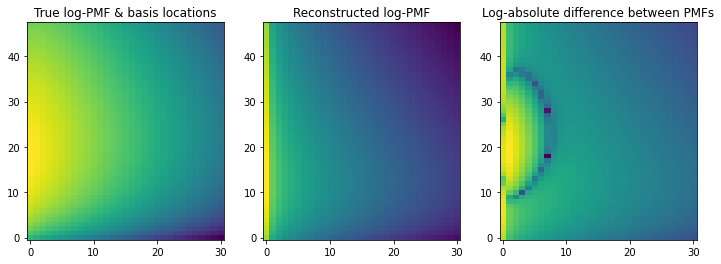

In [86]:
p_num = 200

params[p_num]

tt.plot_PMF(params[p_num:p_num+1],[ys[p_num]],[5,6],model,get_ypred_at_RT,metric)